<a href="https://colab.research.google.com/github/armelida/MELIDA/blob/main/notebooks/MELIDA_Evaluator_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Model LLM Evaluation Notebook

This notebook evaluates **multiple Large Language Models (LLMs)** on a set of standardized test questions. We will start by comparing a few models (2–3) and set up the code to **scale up to 10+ models** easily using an external registry file for model configuration. The evaluation will use a consistent prompt strategy and track performance metrics like accuracy, tokens used, and response time for each model. We’ll also log detailed results per question and export the outcomes to CSV files for visualization (e.g., in Tableau).

**Key features of this notebook:**
- Uses an **external JSON/YAML file** (“model registry”) to define which models to evaluate and how to access them, so you can easily add/remove models without changing code.
- Evaluates each model on a set of **standardized test questions** with a chosen prompt format (e.g., multiple-choice questions) – currently using a zero-shot prompt asking for the best answer.
- Records **metrics per model**: accuracy (percentage of questions answered correctly), total score (number of correct answers), number of tokens used (if available), and average response time.
- Stores **detailed logs per question** and model, including question ID, model name, full input prompt, model’s output, whether it was correct, and latency.
- Exports results to **CSV files** (summary and detailed) for external analysis. We’ll include a guide on how to use these in Tableau to filter by model/prompt/question and create visualizations of accuracy and identify the hardest questions.
- Modular code structure with clear comments and section headings, so you can identify and modify specific parts (e.g., to change the prompt strategy or add new evaluation features like chain-of-thought or hallucination detection in the future).



In [1]:
# Initial Cell:
# Check Runtime & GPU Availability
import torch
import os
import subprocess

def check_runtime():
    """Check whether a GPU or TPU is available."""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        print(f"✅ GPU is enabled! Using: {gpu_name}")
    elif "COLAB_TPU_ADDR" in os.environ:
        print("✅ TPU is enabled!")
    else:
        print("⚠️ WARNING: No GPU or TPU detected. Running on CPU.")
        print("👉 Go to Runtime > Change runtime type > Select GPU/TPU")

def check_gpu():
    """Check GPU details using nvidia-smi if available."""
    try:
        result = subprocess.run(
            ["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        if result.returncode == 0:
            print(result.stdout)
        else:
            print("⚠️ `nvidia-smi` not found. No GPU detected.")
    except FileNotFoundError:
        print("⚠️ No GPU found.")

# Run the checks
check_runtime()
check_gpu()

#  Clone repository and change working directory
!rm -rf MELIDA  # Remove any existing copy (optional)
!git clone https://github.com/armelida/MELIDA.git
%cd MELIDA

✅ GPU is enabled! Using: NVIDIA A100-SXM4-40GB
Mon Mar 31 21:49:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             41W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+

In [2]:
# Cell 0A: Load API Keys & Save API Configuration

!pip install -q python-dotenv
!pip install openai==0.28

import os
import json
from dotenv import load_dotenv

# Initialize API keys dictionary
api_keys = {"openai": None, "anthropic": None, "together": None}

# Try to load from Colab secrets using userdata
try:
    from google.colab import userdata
    api_keys["openai"] = userdata.get('OPENAI_API_KEY')
    api_keys["anthropic"] = userdata.get('ANTHROPIC_API_KEY')
    api_keys["together"] = userdata.get('TOGETHER_API_KEY')
    if api_keys["openai"] and api_keys["anthropic"] and api_keys["together"]:
        print("✓ API keys loaded from Colab secrets")
except Exception as e:
    print(f"Note: Couldn't load from Colab secrets - {e}")

# Fallback: load from environment variables if not loaded yet
if not all(api_keys.values()):
    api_keys["openai"] = api_keys["openai"] or os.environ.get("OPENAI_API_KEY")
    api_keys["anthropic"] = api_keys["anthropic"] or os.environ.get("ANTHROPIC_API_KEY")
    api_keys["together"] = api_keys["together"] or os.environ.get("TOGETHER_API_KEY")
    if api_keys["openai"] or api_keys["anthropic"] or api_keys["together"]:
        print("✓ API keys loaded from environment variables")

# Fallback: load from a .env file if still missing
if not all(api_keys.values()):
    try:
        load_dotenv()  # This will load variables from a .env file in the current directory
        api_keys["openai"] = api_keys["openai"] or os.environ.get("OPENAI_API_KEY")
        api_keys["anthropic"] = api_keys["anthropic"] or os.environ.get("ANTHROPIC_API_KEY")
        api_keys["together"] = api_keys["together"] or os.environ.get("TOGETHER_API_KEY")
        if api_keys["openai"] or api_keys["anthropic"] or api_keys["together"]:
            print("✓ API keys loaded from .env file")
    except Exception as e:
        print(f"Note: Couldn't load from .env file - {e}")

# Propagate keys to os.environ so subsequent cells can access them
if api_keys["openai"]:
    os.environ["OPENAI_API_KEY"] = api_keys["openai"]
if api_keys["anthropic"]:
    os.environ["ANTHROPIC_API_KEY"] = api_keys["anthropic"]
if api_keys["together"]:
    os.environ["TOGETHER_API_KEY"] = api_keys["together"]

# Save API configuration to a JSON file for future reference
os.makedirs('config', exist_ok=True)
api_config = {
    "openai": {"api_key": api_keys["openai"] or "YOUR_OPENAI_API_KEY_HERE"},
    "anthropic": {"api_key": api_keys["anthropic"] or "YOUR_ANTHROPIC_API_KEY_HERE"},
    "together": {"api_key": api_keys["together"] or "YOUR_TOGETHER_API_KEY_HERE"}
}
with open('config/api_config.json', 'w') as f:
    json.dump(api_config, f, indent=2)

# Report missing keys, if any
missing = []
if not api_keys["openai"]:
    missing.append("OpenAI")
if not api_keys["anthropic"]:
    missing.append("Anthropic")
if not api_keys["together"]:
    missing.append("Together")
if missing:
    print(f"⚠ Missing API keys: {', '.join(missing)}")
    print("Please set the API keys using Colab secrets, environment variables, or a .env file.")
else:
    print("✓ Complete API configuration saved")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.69.0
    Uninstalling openai-1.69.0:
      Successfully uninstalled openai-1.69.0
✓ API keys loaded from Colab secrets
✓ Complete API configuration saved


## 1. Setup and Installation (Cell 1)

First, we install and import necessary libraries. This includes:
- **Hugging Face Transformers** for local model inference (if using HuggingFace-hosted models).
- **OpenAI/Anthropic API SDKs** (if using direct APIs like OpenAI’s GPT or Anthropic’s Claude).
- **Together AI** client (if using the Together API for hosted models).
- **PyYAML** (for reading YAML config) and **pandas** (for data manipulation and CSV export).

We will also ensure any required API keys are set (for OpenAI, Anthropic, Together, etc.) via environment variables for security. Replace or set these environment variables before running the evaluation.


In [3]:
# Cell 1: Setup environment and install required packages



# Install required packages
!pip install -q pandas PyYAML openai anthropic together transformers

# Import libraries
import os
import time
import json
import pandas as pd
import yaml  # For YAML parsing (PyYAML)

# Import model API clients
import openai
# Uncomment and ensure your OpenAI API key is available via environment variables
# openai.api_key = os.getenv("OPENAI_API_KEY")

import anthropic
# Uncomment if you plan to use Anthropic API:
# anthropic_client = anthropic.Client(api_key=os.getenv("ANTHROPIC_API_KEY"))

import together
# Uncomment if you plan to use Together API:
# together_client = together.Together(api_key=os.getenv("TOGETHER_API_KEY"))

# (Optional) If using Hugging Face transformers for local models:
try:
    from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
except ImportError:
    !pip install -q transformers
    from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

print("Setup complete. Libraries loaded.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 6.9 MB/s eta 0:00:00
Setup complete. Libraries loaded.


2. Configure Model Registry (Cell 2)
We use an external model registry file (JSON or YAML) to list all models to evaluate and their access details. This file allows easy scaling to more models – just add or remove entries without changing the notebook code. Each model entry can include:
name: A human-readable name for the model (used in results and plots).
provider: The method to access the model (huggingface, together, openai, anthropic, etc.).
model_id: Identifier for the model:
For huggingface, this is the model’s name on HuggingFace Hub (e.g., "google/flan-t5-small").
For together, it might be a model ID known to the Together API (e.g., "meta-llama/Llama-2-7b-chat-hf").
For openai, it could be the API model name (e.g., "gpt-4" or "gpt-3.5-turbo").
For other providers, use the appropriate identifier.
api_key_env (if needed): The environment variable name for the API key (e.g., "OPENAI_API_KEY"). This can be omitted for HuggingFace (if using local models or if no auth needed).
Additional settings like max_tokens, temperature, etc., which define generation parameters for that model.
Example model registry (YAML format):

models:
  - name: FlanT5 Small
    provider: huggingface
    model_id: google/flan-t5-small
    max_tokens: 100
    temperature: 0.0
  - name: GPT-4 (Jan 2025)
    provider: openai
    model_id: gpt-4
    api_key_env: OPENAI_API_KEY
    max_tokens: 100
    temperature: 0.0
  - name: Llama2 7B Chat
    provider: together
    model_id: meta-llama/Llama-2-7b-chat-hf
    max_tokens: 100
    temperature: 0.0

In the code below, we load the model list from the registry file. Update model_config_path to point to your JSON/YAML file. The code will automatically detect JSON vs YAML based on file extension and parse accordingly. After loading, it prints out the model configurations to confirm.

In [4]:
# Cell 2: Load model registry from external JSON/YAML file

# Set the path to your model registry file in the notebooks folder
model_config_path = "notebooks/models.yaml"

# Check if the file exists
if not os.path.exists(model_config_path):
    raise FileNotFoundError(
        f"Model config file not found at {model_config_path}. "
        "Please create it as per the example and update the path."
    )

# Parse the config file (supports YAML and JSON)
if model_config_path.endswith((".yaml", ".yml")):
    with open(model_config_path, 'r') as f:
        config_data = yaml.safe_load(f)
elif model_config_path.endswith(".json"):
    with open(model_config_path, 'r') as f:
        config_data = json.load(f)
else:
    raise ValueError("Unsupported config file format. Use .json or .yaml")

# The config should either be a dict with a top-level 'models' key or a list itself.
if isinstance(config_data, dict) and "models" in config_data:
    models_config = config_data["models"]
elif isinstance(config_data, list):
    models_config = config_data
else:
    raise ValueError("Config file format error: expected a list of models or a 'models' key.")

print(f"Loaded {len(models_config)} models from registry:")
for m in models_config:
    print(f" - {m.get('name', 'Unnamed')} ({m.get('provider', 'Unknown')}, id={m.get('model_id', 'N/A')})")


Loaded 3 models from registry:
 - o3-mini-2025-01-31 (OpenAI, id=o3-mini-2025-01-31)
 - Claude (Anthropic, id=claude-3-7-sonnet-20250219)
 - Together (Together, id=deepseek-ai/DeepSeek-R1)


3. Load Standardized Test Questions (Cell 3)
Next, we prepare the standardized test questions for evaluation. These can be hard-coded, loaded from a file, or generated. In this notebook, we’ll define a list of questions in a structured format (each with an ID, question text, multiple-choice options, and the correct answer). You can replace these with any set of questions relevant to your use case. For demonstration, we’ll use a few simple sample questions. In a real scenario, you might load dozens of questions from a JSON/CSV file or an existing dataset. Ensure each question has a known correct answer to compute accuracy.

In [5]:
# Cell 3: Load extracted exam questions for evaluation

import json
import os

# Define the path to the exported questions file.
# Adjust this path if your exported file name or location is different.
questions_file = "data/questions/MIR-2024-v01-t01.json"

if not os.path.exists(questions_file):
    raise FileNotFoundError(
        f"Questions file not found at {questions_file}. "
        "Please run the extraction process to generate the questions file."
    )

with open(questions_file, 'r', encoding='utf-8') as f:
    questions = json.load(f)

print(f"Loaded {len(questions)} questions for evaluation.")

# Optionally, preview the first three questions
for q in questions[:3]:
    print("---------------------------------------------------")
    print(f"ID: {q['id']}")
    print(f"Question: {q['question_text']}")
    print("Options:")
    for key, value in q['options'].items():
        print(f"  {key}: {value}")
    print("---------------------------------------------------")


Loaded 185 questions for evaluation.
---------------------------------------------------
ID: MIR-2024-v01-t01-Q026
Question: Entre los cambios metabólicos que se observan en un paciente con resistencia a insulina existe:
Options:
  A: Incremento de la expresión hepática de genes gluconeogénicos mediado por FOXO1 (forkhead box other) fosforilado.
  B: Descenso en los niveles intracelulares de hexoquinasa 2 dependiente de insulina.
  C: Aumento de la glucogenólisis muscular, contribuyendo al incremento de la glucemia.
  D: Aumento en los niveles séricos de aminoácidos como leucina e isoleucina.
---------------------------------------------------
---------------------------------------------------
ID: MIR-2024-v01-t01-Q027
Question: La deficiencia de acil-CoA-deshidrogenasa provoca una de las siguientes alteraciones bioquímicas:
Options:
  A: Disminución de ácidos dicarboxílicos.
  B: Aumento de la gluconeogénesis.
  C: Disminución de la ureagénesis.
  D: Aumento de carnitina libre.
-----

Detailed comments: We defined a list of dictionaries, where each dictionary represents a question. Each question has:
id: a unique identifier,
question: the text of the question,
choices: a list of answer choices (as strings, each prefixed with a letter),
answer: the correct choice (here represented by the letter of the correct option).
Feel free to extend or replace this list. For example, you could load questions from a file or generate them. Just ensure each question has a known correct answer for scoring.

4. Define Prompt Strategy (Cell 4)
The prompt strategy determines how we present each question to the model. For standardized test questions, a common strategy is to provide the question and multiple-choice options and ask the model to pick the best answer. We might instruct the model to output just the option letter (to make it easier to check correctness). In future, you could experiment with different strategies (e.g., asking for an explanation, chain-of-thought prompting, etc.). For now, we’ll use a straightforward prompt: the question, the options, and a final instruction like “Answer with the letter of the correct option.” We implement this as a function format_prompt(question) that takes a question entry and returns the full prompt text (or structured prompt) to send to the model. This function can be easily modified if you want to change how prompts are constructed.

In [6]:
# Cell 4: Define the prompt formatting strategy

def format_prompt(q):
    """
    Format a question dictionary into a prompt string for the MIR exam in Spanish.

    The prompt instructs the model to answer with a single letter (A, B, C, D) if it knows the answer,
    or with N if unsure.
    """
    # Get the main question text
    question_text = q.get("question_text", "")

    # Get each answer option from the options dictionary (default to empty string if missing)
    options = q.get("options", {})
    option_a = options.get("A", "")
    option_b = options.get("B", "")
    option_c = options.get("C", "")
    option_d = options.get("D", "")

    # Build the prompt using the provided format
    prompt = (
        "Eres un Médico que está realizando el examen MIR, un test estandarizado en español que determinará si obtienes tu residencia. "
        "Responde a la siguiente pregunta exactamente como se indica. Si conoces la respuesta, responde ÚNICAMENTE con una de las letras A, B, C o D. "
        "Si no estás seguro, responde con N. Cualquier texto adicional invalidará tu respuesta y restará puntos.\n\n"
        f"{question_text}\n\n"
        f"A) {option_a}\n"
        f"B) {option_b}\n"
        f"C) {option_c}\n"
        f"D) {option_d}\n\n"
        "Tu respuesta (ÚNICAMENTE una letra: A, B, C, D o N si no estás seguro):"
    )
    return prompt

# Test the prompt formatting on the first loaded question
example_prompt = format_prompt(questions[0])
print("Example formatted prompt:\n", example_prompt)


Example formatted prompt:
 Eres un Médico que está realizando el examen MIR, un test estandarizado en español que determinará si obtienes tu residencia. Responde a la siguiente pregunta exactamente como se indica. Si conoces la respuesta, responde ÚNICAMENTE con una de las letras A, B, C o D. Si no estás seguro, responde con N. Cualquier texto adicional invalidará tu respuesta y restará puntos.

Entre los cambios metabólicos que se observan en un paciente con resistencia a insulina existe:

A) Incremento de la expresión hepática de genes gluconeogénicos mediado por FOXO1 (forkhead box other) fosforilado.
B) Descenso en los niveles intracelulares de hexoquinasa 2 dependiente de insulina.
C) Aumento de la glucogenólisis muscular, contribuyendo al incremento de la glucemia.
D) Aumento en los niveles séricos de aminoácidos como leucina e isoleucina.

Tu respuesta (ÚNICAMENTE una letra: A, B, C, D o N si no estás seguro):


Detailed comments: The format_prompt function takes a question from our list and builds a prompt. We put the question text, list all the choices (joined in one line for simplicity), and then give an explicit instruction. By asking for the letter only, we aim to have consistent outputs that are easy to check (the model hopefully will just respond with “B”, etc.). After defining the function, we preview an example prompt for the first question to verify the format. You can adjust this format as needed (for instance, if a model tends to do better with a different phrasing or if you want the model to explain its answer, etc.).

In [7]:
# Cell 5: Define function to call a model and get its response (final version for Anthropic)
import time
import os
import openai
import anthropic
import together
from transformers import pipeline, AutoTokenizer

def call_model(model_cfg, prompt):
    """
    Call a model with the given prompt and return its response and metadata.
    Returns: output_text, tokens_used, latency
    """
    provider = model_cfg.get("provider", "").lower()
    model_id = model_cfg.get("model_id")
    # Use max_tokens from models.yaml (set to 2000) and temperature 0.0
    max_tokens = model_cfg.get("max_tokens", 2000)
    temperature = model_cfg.get("temperature", 0.0)
    tokens_used = None
    output_text = ""
    start_time = time.time()

    if provider == "huggingface":
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        if "google/flan" in model_id.lower() or "t5" in model_id.lower():
            pipe = pipeline("text2text-generation", model=model_id, tokenizer=tokenizer)
            result = pipe(prompt, max_length=max_tokens, temperature=temperature)
            output_text = result[0]['generated_text']
        else:
            pipe = pipeline("text-generation", model=model_id, tokenizer=tokenizer)
            result = pipe(prompt, max_length=max_tokens, temperature=temperature, do_sample=False)
            output_text = result[0]['generated_text']
        try:
            input_tokens = tokenizer(prompt, return_tensors="pt")["input_ids"]
            output_tokens = tokenizer(output_text, return_tensors="pt")["input_ids"]
            tokens_used = int(len(input_tokens[0]) + len(output_tokens[0]))
        except Exception:
            tokens_used = None

    elif provider == "openai":
        # OpenAI branch using ChatCompletion (remember to pin openai==0.28 if using o3-mini)
        if os.getenv(model_cfg.get("api_key_env", "OPENAI_API_KEY")) is None:
            raise RuntimeError(f"OpenAI API key not set for model {model_cfg.get('name', model_id)}")
        try:
            if "o3-mini" in model_id.lower():
                response = openai.ChatCompletion.create(
                    model=model_id,
                    messages=[{"role": "user", "content": prompt}],
                    max_completion_tokens=max_tokens
                )
            else:
                response = openai.ChatCompletion.create(
                    model=model_id,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=max_tokens,
                    temperature=temperature
                )
            output_text = response['choices'][0]['message']['content'].strip()
            if 'usage' in response:
                tokens_used = response['usage'].get('total_tokens')
        except Exception as e:
            raise RuntimeError(f"Error calling OpenAI model: {e}")

    elif provider == "anthropic":
        # Anthropic branch using the Messages API with proper parameters
        if os.getenv(model_cfg.get("api_key_env", "ANTHROPIC_API_KEY")) is None:
            raise RuntimeError(f"Anthropic API key not set for model {model_cfg.get('name', model_id)}")
        try:
            anthropic_client = anthropic.Client(api_key=os.getenv(model_cfg.get("api_key_env", "ANTHROPIC_API_KEY")))
            response = anthropic_client.messages.create(
                model=model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature,
                stream=False
            )
            # Extract output_text from response:
            if isinstance(response, dict):
                output_text = response.get("completion", "").strip()
            else:
                try:
                    output_text = response.completion.strip()
                except AttributeError:
                    output_text = str(response).strip()
        except Exception as e:
            raise RuntimeError(f"Error calling Anthropic model: {e}")
        tokens_used = None

    elif provider == "together":
        # Together branch using their chat completions API
        if os.getenv(model_cfg.get("api_key_env", "TOGETHER_API_KEY")) is None:
            raise RuntimeError(f"Together API key not set for model {model_cfg.get('name', model_id)}")
        try:
            together_client = together.Together(api_key=os.getenv(model_cfg.get("api_key_env", "TOGETHER_API_KEY")))
            response = together_client.chat.completions.create(
                model=model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature,
                stream=False
            )
            try:
                output_text = response.choices[0].message.content.strip()
            except Exception:
                output_text = response['choices'][0]['message']['content'].strip() if isinstance(response, dict) else str(response)
        except Exception as e:
            raise RuntimeError(f"Error calling Together model: {e}")
        tokens_used = None

    else:
        raise ValueError(f"Unknown provider: {provider} for model {model_cfg.get('name', model_id)}")

    latency = time.time() - start_time
    return output_text, tokens_used, latency


5. Model Interface and Evaluation Functions (Cells 5–6)
In this section, we set up functions to handle model inference and evaluation:
call_model(model_config, prompt_text) – Invokes a single model (based on its provider and config) with the given prompt, and returns the model’s answer, along with metadata like token usage and latency.
evaluate_model(model_config, questions) – Uses call_model to get answers for each question from one model, checks correctness, and collects detailed results.
We will also prepare a loop or another function to evaluate all models and aggregate the results for comparison.
Structuring this logic into functions makes the notebook modular and easier to update. For example, if in the future we want to add a step for chain-of-thought (CoT) prompting or filter the model output for hallucinations, we could modify or wrap call_model accordingly. 5.1 call_model Implementation: This function will branch based on the provider:
HuggingFace: use transformers pipeline or model generate. We’ll initialize a pipeline for text generation or use the model’s generate method. We also tokenize the input to count input tokens. The output tokens can be counted by the tokenizer as well.
OpenAI: use openai.Completion or openai.ChatCompletion depending on model type. For chat models (e.g., GPT-4), we pass the prompt as a user message. We retrieve the output text and usage info (token counts).
Anthropic: (Claude models) use anthropic’s client. Typically you provide a prompt with a special format (like "\n\nHuman: <question>\n\nAssistant:"). We skip detailed implementation here but it can be added.
Together: use Together API client. For example, together_client.complete or the chat completion as needed, based on their documentation. (Ensure TOGETHER_API_KEY is set.)
Additional providers (e.g., Cohere, AI21) can be integrated similarly by adding new branches.
We also measure the time taken for each call (latency). If token counts are not readily available from the API, we will set them to None (or you could estimate via a tokenizer). Let’s implement call_model below:

Detailed comments: In call_model:
We take the model’s config and a prompt string.
Based on provider, we handle the call differently.
HuggingFace: We load the model and tokenizer (from local or HuggingFace Hub). We use pipeline for simplicity (it will handle the model loading and generation). We choose the pipeline task based on model type (a quick check for “t5” in the model name to decide between text2text-generation and text-generation). After generation, we count tokens by encoding the prompt and output with the tokenizer.
OpenAI: We use the OpenAI API. If the model is chat-based (we guess by name containing “gpt-3.5” or “gpt-4”), we use the ChatCompletion endpoint with a single user message. Otherwise, we use the older Completion endpoint. We fetch the text from the response and also get token usage if provided. (Make sure your OpenAI API key is set in the environment.)
Anthropic: We format the prompt in the required way for Claude and call the client’s completion method. (This assumes the anthropic package is installed and imported.) Token count isn’t directly captured here.
Together: We initialize the Together client and call the chat.completions.create method with the prompt as a user message. (This assumes the model supports chat format; for pure text-generation models on Together, you might use a different method like client.completion.create.) We extract the content from the response. (Token usage may be available via Together’s response, but for simplicity, we set it to None in this example.)
We measure the time just before and after the call to compute latency.
Finally, we return output_text (the model’s answer), tokens_used, and latency.
This function abstracts away the differences in model access, giving us a unified interface for the evaluation loop.

5.2 evaluate_model Implementation: This function will loop through all questions for a single model, use call_model to get the answer, check correctness, and record results. It will return a list of result records (one per question for that model) and also compute summary metrics (like number correct). We’ll implement evaluate_model next:

In [8]:
import json
import os

# Define file paths
original_questions_file = 'data/questions/MIR-2024-v01-t01.json'
answer_key_file = 'data/answers/MIR-2024-v01-t01-answers.json'
filtered_questions_file = 'data/questions/MIR-2024-v01-t01_filtered.json'

# Load answer key (assumed to be a dictionary with question IDs as keys)
with open(answer_key_file, 'r', encoding='utf-8') as f:
    answer_key = json.load(f)

# Load original questions (assumed to be a list)
with open(original_questions_file, 'r', encoding='utf-8') as f:
    questions = json.load(f)

# Filter out questions that are not in the answer key or whose answer is empty
filtered_questions = [
    q for q in questions
    if q.get('id') in answer_key and answer_key[q.get('id')].strip() != ""
]

# Save filtered questions to a new file
with open(filtered_questions_file, 'w', encoding='utf-8') as f:
    json.dump(filtered_questions, f, indent=2)

print(f"Filtered questions saved to {filtered_questions_file} with {len(filtered_questions)} questions out of {len(questions)} original questions.")


Filtered questions saved to data/questions/MIR-2024-v01-t01_filtered.json with 180 questions out of 185 original questions.


In [9]:
# Cell 6.1: Patch OpenAI to support legacy calls in evaluator.py and reload evaluator module

!pip install openai==0.28

import openai

# Define a wrapper class so that openai.chat.completions.create(...) works.
class ChatCompletionsWrapper:
    @staticmethod
    def create(*args, **kwargs):
        return openai.ChatCompletion.create(*args, **kwargs)

class OpenAIChatWrapper:
    completions = ChatCompletionsWrapper

# Assign our wrapper to openai.chat
openai.chat = OpenAIChatWrapper

# Verify the patch:
print("openai.chat.completions.create:", openai.chat.completions.create)

# Reload evaluator so that it picks up our patched openai
import importlib
import src.evaluator as evaluator_module
importlib.reload(evaluator_module)
from src.evaluator import ModelEvaluator

print("OpenAI version:", openai.__version__)


openai.chat.completions.create: <function ChatCompletionsWrapper.create at 0x7f6305765d00>
OpenAI version: 0.28.0


In [10]:
#6.2
import re
import json
from src.evaluator import ModelEvaluator

def extract_answer_letter(output):
    """
    Extracts the first valid answer letter (A, B, C, D, or N) from the model output.
    """
    match = re.search(r'\b([ABCDN])\b', output.upper())
    return match.group(1) if match else None

# Define parameters (only include supported models)
models_to_test = ['o3-mini-2025-01-31', 'claude-3-7-sonnet-20250219']
prompt_strategy = "Prompt-001"
sample_size = 5  # Evaluate 5 questions per model

# Use the filtered questions file instead of the original
filtered_questions_file = 'data/questions/MIR-2024-v01-t01_filtered.json'
answer_key_file = 'data/answers/MIR-2024-v01-t01-answers.json'

# Initialize the evaluator
evaluator = ModelEvaluator()

results_summary = {}

print("\n--- RUNNING SAMPLE EVALUATION ---")
for model in models_to_test:
    print(f"\nEvaluating Model: {model} using Prompt Strategy: {prompt_strategy}")
    try:
        result_file = evaluator.run_evaluation(
            questions_file=filtered_questions_file,  # Use filtered questions here
            answer_key_file=answer_key_file,
            prompt_strategy=prompt_strategy,
            model=model,
            sample_size=sample_size
        )
        print(f"✓ Sample evaluation complete for {model}. Results saved to: {result_file}")

        with open(result_file, 'r') as f:
            results = json.load(f)
        details = results.get("details", [])
        if details:
            print("\n--- DETAILS FOR EACH QUESTION ---")
            for entry in details:
                question_id = entry.get("question_id", "N/A")
                question_prompt = entry.get("prompt", "No prompt available")
                raw_output = entry.get("model_output", "No output")
                extracted = extract_answer_letter(raw_output)
                entry["extracted_answer"] = extracted
                print(f"Question ID: {question_id}")
                print("Prompt:")
                print(question_prompt)
                print("Raw Output:")
                print(raw_output)
                print("Extracted Answer:", extracted)
                print("-"*40)
        else:
            print("\nNo per-question details found in the evaluation results.")

        summary = results.get("summary", {})
        results_summary[model] = summary

        print("\n--- SAMPLE EVALUATION SUMMARY ---")
        print(f"Model: {summary.get('model', 'N/A')}")
        print(f"Prompt Strategy: {summary.get('prompt_strategy', 'N/A')}")
        print(f"Total Questions: {summary.get('total_questions', 'N/A')}")
        print(f"Correct Answers: {summary.get('correct_count', 'N/A')} ({summary.get('accuracy', 0)*100:.2f}%)")
        print(f"Incorrect Answers: {summary.get('incorrect_count', 'N/A')}")
        print(f"Skipped Questions: {summary.get('skipped_count', 'N/A')}")
        print(f"Invalid Count: {summary.get('invalid_count', 'N/A')}")
        print(f"Total Score: {summary.get('total_score', 'N/A')}")
    except Exception as e:
        print(f"✗ Error during sample evaluation for {model}: {e}")

print("\nIf the sample evaluation looks good, proceed to full evaluation in the next cell.")



--- RUNNING SAMPLE EVALUATION ---

Evaluating Model: o3-mini-2025-01-31 using Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


✓ Sample evaluation complete for o3-mini-2025-01-31. Results saved to: data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-o3-mini-2025-01-31-20250331-215024.json

No per-question details found in the evaluation results.

--- SAMPLE EVALUATION SUMMARY ---
Model: o3-mini-2025-01-31
Prompt Strategy: Prompt-001
Total Questions: 5
Correct Answers: 5 (100.00%)
Incorrect Answers: 0
Skipped Questions: 0
Invalid Count: 0
Total Score: 15

Evaluating Model: claude-3-7-sonnet-20250219 using Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]

✓ Sample evaluation complete for claude-3-7-sonnet-20250219. Results saved to: data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250331-215031.json

No per-question details found in the evaluation results.

--- SAMPLE EVALUATION SUMMARY ---
Model: claude-3-7-sonnet-20250219
Prompt Strategy: Prompt-001
Total Questions: 5
Correct Answers: 4 (80.00%)
Incorrect Answers: 1
Skipped Questions: 0
Invalid Count: 0
Total Score: 11

If the sample evaluation looks good, proceed to full evaluation in the next cell.


Detailed comments: In evaluate_model:
We iterate over each question, format the prompt, and call the model via call_model.
We wrap the model call in a try-except to catch any errors (for instance, if an API call fails or a model isn’t available). If there’s an error, we log it and move on, leaving output empty for that question.
We then parse the model’s output to extract the answer. We assume the model should reply with a letter. The code checks the first character of the output: if it’s one of “A, B, C, D”, we treat that as the chosen option. (If the output is something else, you could include additional parsing logic – for example, sometimes the model might output the full option text or a sentence. Here, we simplify by taking the first letter when possible. If the output is empty or doesn’t start with a letter, we mark the answer as incorrect by default.)
We compare the model’s answer letter (uppercased) to the true answer letter from the question. If they match, it’s correct and we increment correct_count.
We append a dictionary to results containing all relevant info: question ID, model name, the exact prompt used, the model’s raw output, a boolean for correctness, latency (in seconds), and tokens used.
We also print a one-line progress update for each question, indicating what the model answered and whether it was correct. This helps to monitor the evaluation as it happens, especially if many questions are being tested.
Finally, the function returns the list of results and the count of correct answers.
With these functions in place, we can now evaluate all models and compile the metrics.
6. Run Evaluation for All Models (Cell 7)
Now we’ll loop through each model in our models_config, evaluate it on all questions using evaluate_model, and collect the outcomes. We will calculate summary metrics for each model:
Accuracy (% correct)
Total score (number of correct answers out of total questions)
Total tokens used (if available; this could be sum of tokens across all questions for that model)
Average response time per question (latency)
We’ll store summary results in a list of dictionaries (which we can later convert to a DataFrame for display or CSV export). We’ll also accumulate all per-question results into a single list for detailed logging.

In [11]:
# Cell 7: Run Full Evaluation
import os
import json
from src.evaluator import ModelEvaluator

# Define which models to evaluate (only include those that are supported)
models_to_evaluate = ['o3-mini-2025-01-31', 'claude-3-7-sonnet-20250219']
# Define prompt strategies to test – you can add more if desired
prompt_strategies = ["Prompt-001"]

# Use the filtered questions file (created in Cell 6.0) and the original answer key file
questions_file = 'data/questions/MIR-2024-v01-t01_filtered.json'
answer_key_file = 'data/answers/MIR-2024-v01-t01-answers.json'

# Initialize the evaluator
evaluator = ModelEvaluator()

result_files = []

print("\n--- RUNNING FULL EVALUATION ---")
for model in models_to_evaluate:
    for prompt_strategy in prompt_strategies:
        print(f"\nEvaluating Model: {model} with Prompt Strategy: {prompt_strategy}")
        try:
            # Use sample_size=None to evaluate all questions
            result_file = evaluator.run_evaluation(
                questions_file=questions_file,
                answer_key_file=answer_key_file,
                prompt_strategy=prompt_strategy,
                model=model,
                sample_size=None
            )
            result_files.append(result_file)
            print(f"✓ Evaluation complete for {model} with {prompt_strategy}. Results saved to: {result_file}")
        except Exception as e:
            print(f"✗ Error during evaluation for Model: {model} with Prompt Strategy: {prompt_strategy}: {e}")

print("\n--- FULL EVALUATION COMPLETE ---")
print(f"Generated {len(result_files)} result file(s):")
for rf in result_files:
    print(rf)



--- RUNNING FULL EVALUATION ---

Evaluating Model: o3-mini-2025-01-31 with Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 180/180 [15:58<00:00,  5.33s/it]


✓ Evaluation complete for o3-mini-2025-01-31 with Prompt-001. Results saved to: data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-o3-mini-2025-01-31-20250331-220630.json

Evaluating Model: claude-3-7-sonnet-20250219 with Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 180/180 [03:57<00:00,  1.32s/it]

✓ Evaluation complete for claude-3-7-sonnet-20250219 with Prompt-001. Results saved to: data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250331-221027.json

--- FULL EVALUATION COMPLETE ---
Generated 2 result file(s):
data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-o3-mini-2025-01-31-20250331-220630.json
data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250331-221027.json


Detailed comments: In Cell 7:
We initialize all_details to gather every question’s result and summary_records for each model.
We loop over each model configuration:
* Call evaluate_model for that model, which returns the detailed results and count of correct answers.
* We extend the all_details list with the results (so in the end, this list contains an entry for each model-question pair).
* Compute accuracy as (num_correct / total_questions) * 100. We round it to two decimal places later for neatness.
* Compute total tokens used by summing the tokens_used for each question result, if available. If none of the results have token info (i.e., the list is empty because maybe the API didn’t provide it), we leave total_tokens as None.
* Compute average latency by summing all latencies and dividing by number of questions (we exclude any None latencies just in case).
* Append a dictionary to summary_records with the model’s name and metrics. We include total questions for reference, and round the accuracy and average latency for readability.
* Print a summary line for each model (e.g., “Finished ModelX: 8/10 correct, Accuracy 80.0%.”).
After this loop, we have:
* summary_records: a list of summary info for each model.
* all_details: a list of per-question info, which we can turn into a detailed log.
Next, we’ll convert these to pandas DataFrames for easy viewing and export.

In [12]:
# =========================
# FINAL EXPORT CELL: Full Evaluation Results to CSV, GitHub, & Download
# =========================

import glob
import json
import pandas as pd
import os
from datetime import datetime
import shutil
import subprocess
from google.colab import files
from google.colab import userdata

# --- Step 1: Gather Full Evaluation Result Files ---
# Adjust the glob pattern if necessary to include only full evaluation files.
# (This example assumes your full evaluation result files contain "filtered" in the filename.)
result_files = glob.glob("data/results/EVAL-MIR-2024-v01-t01_filtered-*.json")
print(f"Found {len(result_files)} full evaluation result file(s).")

# --- Step 2: Merge Detailed Evaluation Results ---
# We assume each JSON file contains detailed results under either the "details" or "results" key.
all_details = []
for file in result_files:
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        details = data.get('details') or data.get('results')
        if details:
            all_details.extend(details)
    except Exception as e:
        print(f"Error processing {file}: {e}")

if not all_details:
    print("No detailed evaluation results were found in the JSON files.")
else:
    # Convert the merged results to a DataFrame.
    df_full = pd.DataFrame(all_details)
    print("Merged full evaluation results shape:", df_full.shape)
    print("Columns in full evaluation results:", df_full.columns.tolist())

    # --- Step 3: Export Merged Results to a Single CSV File ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    export_filename = f"full_evaluation_results_{timestamp}.csv"
    export_dir = os.path.join("data", "exports")
    os.makedirs(export_dir, exist_ok=True)
    export_path = os.path.join(export_dir, export_filename)
    df_full.to_csv(export_path, index=False)
    print(f"✓ Full evaluation results exported to CSV: {export_path}")

    # --- Step 4: Download the CSV File Locally (Colab) ---
    files.download(export_path)

    # --- Step 5: Push the CSV File to GitHub ---
    try:
        # Retrieve GitHub token from Colab secrets
        github_token = userdata.get('GITHUB_TOKEN')
        if not github_token:
            raise ValueError("GITHUB_TOKEN is not set in Colab secrets.")

        # Configure the remote URL with your GitHub token
        repo_name = "armelida/MELIDA"
        token_url = f"https://{github_token}@github.com/{repo_name}.git"

        subprocess.run(["git", "config", "--global", "user.email", "armelida@gmail.com"], check=True)
        subprocess.run(["git", "config", "--global", "user.name", "Armelida"], check=True)
        subprocess.run(["git", "remote", "set-url", "origin", token_url], check=True)

        # Stage the new CSV file for commit.
        subprocess.run(["git", "add", export_path], check=True)
        commit_message = f"Export full evaluation results {timestamp}"
        subprocess.run(["git", "commit", "-m", commit_message], check=True)

        # Pull the latest changes and then push your commit.
        subprocess.run(["git", "pull", "origin", "main", "--rebase"], check=True)
        subprocess.run(["git", "push", "origin", "main"], check=True)
        print("✓ CSV file successfully pushed to GitHub.")
    except Exception as e:
        print(f"Error during GitHub push: {e}")


Found 8 full evaluation result file(s).
Merged full evaluation results shape: (740, 11)
Columns in full evaluation results: ['question_id', 'prompt_strategy', 'model', 'model_answer', 'raw_response', 'response_time', 'tokens_used', 'timestamp', 'correct_answer', 'score', 'result_id']
✓ Full evaluation results exported to CSV: data/exports/full_evaluation_results_20250331_221027.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ CSV file successfully pushed to GitHub.


In [16]:
# =========================
# CELL: Export Most Failed Questions CSV
# =========================

import glob
import pandas as pd
import os
from datetime import datetime

# (Optional) Load the most recent full evaluation CSV from your exports folder:
export_files = sorted(glob.glob("data/exports/full_evaluation_results_*.csv"))
if export_files:
    latest_export = export_files[-1]
    df_full = pd.read_csv(latest_export)
    print(f"Loaded merged full evaluation results from: {latest_export}")
else:
    raise FileNotFoundError("No full evaluation CSV file found in data/exports/.")

# Standardize answer columns and compute correctness.
df_full['model_answer'] = df_full['model_answer'].astype(str).str.strip().str.upper()
df_full['correct_answer'] = df_full['correct_answer'].astype(str).str.strip().str.upper()
df_full['raw_response'] = df_full['raw_response'].astype(str).str.strip()
df_full['correct'] = df_full['model_answer'] == df_full['correct_answer']

# Determine which column to use for question text.
if 'prompt' in df_full.columns:
    question_text_col = 'prompt'
elif 'question_text' in df_full.columns:
    question_text_col = 'question_text'
else:
    # If no column exists, create one with a default value.
    df_full['question_text'] = "Not available"
    question_text_col = 'question_text'

# Filter out only the failed evaluations.
df_failures = df_full[~df_full['correct']]

# Group by question_id to aggregate failure information.
df_failures_summary = df_failures.groupby("question_id").agg(
    failure_count=("model", "count"),
    models_failed=("model", lambda x: ", ".join(sorted(x.unique()))),
    correct_answer=("correct_answer", "first"),
    raw_responses=("raw_response", lambda x: " || ".join(x.astype(str).unique())),
    question_text=(question_text_col, "first")
).reset_index()

# Sort by failure_count descending (most failed questions at the top).
df_failures_summary = df_failures_summary.sort_values("failure_count", ascending=False)

# Save the summary to a CSV file.
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
failed_csv = f"most_failed_questions_{timestamp}.csv"
export_dir = os.path.join("data", "exports")
os.makedirs(export_dir, exist_ok=True)
export_path = os.path.join(export_dir, failed_csv)
df_failures_summary.to_csv(export_path, index=False)
print(f"✓ Most failed questions exported to CSV: {export_path}")

# Optionally, display the DataFrame.
print("=== Most Failed Questions ===")
print(df_failures_summary.to_string(index=False))


Loaded merged full evaluation results from: data/exports/full_evaluation_results_20250331_221027.csv
✓ Most failed questions exported to CSV: data/exports/most_failed_questions_20250331_222905.csv
=== Most Failed Questions ===
          question_id  failure_count                                  models_failed correct_answer raw_responses question_text
MIR-2024-v01-t01-Q027              4                     claude-3-7-sonnet-20250219              C             D Not available
MIR-2024-v01-t01-Q043              4 claude-3-7-sonnet-20250219, o3-mini-2025-01-31              B             C Not available
MIR-2024-v01-t01-Q068              4 claude-3-7-sonnet-20250219, o3-mini-2025-01-31              B      nan || A Not available
MIR-2024-v01-t01-Q181              4 claude-3-7-sonnet-20250219, o3-mini-2025-01-31              B      D || nan Not available
MIR-2024-v01-t01-Q206              4 claude-3-7-sonnet-20250219, o3-mini-2025-01-31              D             C Not available
MIR-2024-v0

In [ ]:
# Cell 9: Export Evaluation Results to GitHub (Copy files, commit, pull, and push)
from google.colab import userdata
import os
import shutil
import subprocess
from datetime import datetime  # Import datetime here

# Step 1: Copy evaluation result files from data/results/ (excluding the "prompting-strategy" folder)
# to data/results/prompting-strategy/
source_dir = "data/results"
target_dir = os.path.join(source_dir, "prompting-strategy")
os.makedirs(target_dir, exist_ok=True)

# Define file extensions to copy
extensions = (".json", ".csv", ".png")

# Iterate over files in the source directory
for filename in os.listdir(source_dir):
    # Skip the target folder itself
    if filename == "prompting-strategy":
        continue
    # Process files with specified extensions
    if filename.endswith(extensions):
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)
            print(f"Copied {src_path} to {dst_path}")
        else:
            print(f"Skipped copying {src_path} (already exists in target)")

# Step 2: Push the updated results to GitHub using your GitHub token
try:
    # Retrieve GitHub token from Colab secrets
    github_token = userdata.get('GITHUB_TOKEN')
    if not github_token:
        raise ValueError("GITHUB_TOKEN is not set in Colab secrets.")

    # Define repository name and construct token URL (adjust repository name as needed)
    repo_name = "armelida/MELIDA"
    token_url = f"https://{github_token}@github.com/{repo_name}.git"

    # Configure Git user details
    subprocess.run(["git", "config", "--global", "user.email", "armelida@gmail.com"], check=True)
    subprocess.run(["git", "config", "--global", "user.name", "Armelida"], check=True)

    # Update the remote URL to include the token
    subprocess.run(["git", "remote", "set-url", "origin", token_url], check=True)

    # Stage all changes (including the prompting-strategy folder)
    subprocess.run(["git", "add", "-A"], check=True)

    # Commit changes (if any). This command may output a message if there is nothing to commit.
    commit_message = f"Auto commit evaluation results from {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    commit_proc = subprocess.run(
        ["git", "commit", "-m", commit_message],
        capture_output=True,
        text=True
    )
    print("Git commit output:", commit_proc.stdout, commit_proc.stderr)

    # Pull the latest changes with rebase
    pull_proc = subprocess.run(
        ["git", "pull", "origin", "main", "--rebase"],
        capture_output=True,
        text=True,
        check=True
    )
    print("Git pull output:", pull_proc.stdout, pull_proc.stderr)

    # Push the committed changes to GitHub
    push_proc = subprocess.run(
        ["git", "push", "origin", "main"],
        capture_output=True,
        text=True,
        check=True
    )
    print("Git push output:", push_proc.stdout, push_proc.stderr)
    print("Results successfully pushed to GitHub")
except subprocess.CalledProcessError as cpe:
    print("Error during git operation:")
    print("Return code:", cpe.returncode)
    print("Output:", cpe.output)
    print("Error output:", cpe.stderr)
except Exception as e:
    print(f"Error pushing to GitHub: {e}")


Skipped copying data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.json (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250326-154417.json (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250326-154417.csv (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-225634.json (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-o3-mini-2025-01-31-20250326-154408.csv (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.csv (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-o3-mini-2025-01-31-20250326-154408.json (already exists in target)
Skipped copying data/results/EVAL-MIR-2024-v01-t01-Prompt-002-claude-3-7-s

Detailed comments: We create two DataFrames:
summary_df with one row per model, containing accuracy, scores, etc.
details_df with one row per question per model, containing everything from question ID to correctness.
We then display the summary and the first few detailed results to verify the content. (In a real Jupyter environment, display(df) will show a nice table. In a text environment or script, you might use print(df.to_string()) or df.head().) Review the summary to ensure metrics make sense, and review the details to spot-check that outputs and correctness are recorded as expected.

7. Export Results to CSV (Cell 8)
Now that we have the results in DataFrames, we’ll export them to CSV files, which can be used in external analysis tools like Excel or Tableau. We will create two CSV files:
llm_eval_summary.csv – containing the summary metrics per model.
llm_eval_details.csv – containing the detailed per-question results.
These files will include headers and can be imported directly into Tableau or other tools.

After running this, you should find two CSV files in your working directory:
llm_eval_summary.csv – with columns like model_name, accuracy (%), total_score, total_questions, tokens_used_total, avg_latency_sec.
llm_eval_details.csv – with columns like question_id, model_name, prompt, model_output, correct, latency, tokens_used.
These can now be loaded into Tableau or any data analysis software for visualization.

8. Using Tableau for Analysis of Results
With the results exported, we can analyze and visualize the performance of the models. Below are step-by-step instructions to use Tableau (or a similar data visualization tool) to explore the data:
Import the CSV files into Tableau: Open Tableau and connect to the llm_eval_summary.csv and llm_eval_details.csv files (you can import them separately or join/relate them on the model_name field if needed).
Summary Dashboard (Model-Level): Using llm_eval_summary.csv, you can create a simple chart of model performance. For example:
Create a bar chart with model_name on the x-axis and accuracy (%) on the y-axis to compare accuracy across models.
Add labels to show the exact accuracy or score for each model bar.
You could also include avg_latency_sec as a secondary metric (perhaps a separate chart or as a tooltip) to see the speed-accuracy tradeoff.
Filter by Prompt or Question: Since all models used the same prompt strategy in this run, the summary is straightforward. If you had different prompt strategies or sets of questions, you could use filters. For instance, if prompt_strategy was a field, you could filter or color-code by it. Or using the detailed data, you could filter to a specific question to see all model answers for that one.
Detailed Analysis (Question-Level): Using llm_eval_details.csv, you can analyze which questions were hardest:
Create a view with question_id on one axis and perhaps the count of models that got it correct.
For example, drag question_id to rows, and an aggregation of correct (treat correct as 0/1 values and take average or sum). Multiply by 100 to interpret as percentage of models correct. This will tell you the percent of models that answered each question correctly.
Identify questions with low scores across models – these are the hardest questions. You can highlight them or filter to the hardest 5 questions.
You can also create a detail table showing each model’s answer (from model_output) for a given question by filtering question_id and listing model_name and model_output for context.
Visualization Examples: You might create a dashboard with two charts – one showing model accuracy comparison, and another showing a difficulty analysis of questions. Use color or annotations to highlight interesting findings (e.g., a particular model that outperforms others, or a question that stumped half the models).


Example: A simple bar chart comparing model accuracy. In the figure above, each bar represents a model’s accuracy on the test set (e.g., GPT-4 achieved 100% on 3 questions, whereas a smaller FlanT5 model scored 66.7%). You can create similar charts in Tableau easily by dragging and dropping the accuracy (%) field for each model_name. Remember, you can use Tableau’s filters to focus on specific models or questions. For instance, a filter on model_name could let you compare any subset of models (e.g., comparing only GPT-4.5-Preview vs. Gemini-2.0), and a filter on question_id could let you inspect performance on individual questions. Note: Ensure that in Tableau, boolean fields like correct are treated appropriately (Tableau might import them as text "TRUE"/"FALSE"). You may want to create a calculated field like Correct (0/1) as IF [correct] THEN 1 ELSE 0 END for easier aggregation.
9. Future Enhancements and Conclusion
We designed this notebook to be modular and easy to extend. Here are a few ways you could build on this framework:
Chain-of-Thought Prompting: Modify the format_prompt function or the evaluation loop to incorporate chain-of-thought (CoT) prompts (e.g., by asking the model to "think step by step" before answering, and then evaluating the final answer separately). You could then evaluate not just the final answer accuracy but also analyze the reasoning steps.
Hallucination Detection: If the questions have definitive answers, any divergence in the model’s explanation could be flagged. You might extend the detailed logs with fields for whether the model’s explanation contains factual errors (this could be manual or via another automated checker).
Additional Metrics: We tracked token usage and latency. You could also log prompt length or output length separately, or cost if using paid APIs (by multiplying token usage by cost per token).
More Providers: You can easily add new model providers (Cohere, AI21, etc.) in the call_model function. Just include a new elif branch and use their SDK or HTTP calls.
Finally, a note on the evaluator.py (if you have a separate script for evaluation):
To support token and time tracking, ensure that evaluator.py captures the start and end time around model invocations (as we did with time.time() in call_model) and returns or logs the duration.
Modify the evaluator to also return the model’s raw output and any usage stats if available. For example, if originally it only returned correctness, have it return a dict with keys like output, correct, tokens_used, latency.
To make it compatible with multi-model comparison, you could refactor evaluator.py to accept a model config or identifier as a parameter, so it can be called in a loop for different models (similar to how we did with evaluate_model). It could also be extended to handle a list of models internally and produce a combined report.
By implementing these modifications, the evaluation pipeline will be more robust and informative. The modular structure of this notebook should make such changes straightforward – each component (prompt formatting, model calling, result aggregation) can be adjusted independently. Conclusion: You now have a complete pipeline to evaluate multiple LLMs side-by-side on standardized questions, with results ready for analysis. Feel free to experiment with different models (just update the registry file), add more questions, or tweak the prompt strategy. Happy evaluating!
Copy
Edit






Found 8 evaluation result files.
Merged details shape: (882, 11)
Columns in details: ['question_id', 'prompt_strategy', 'model', 'model_answer', 'raw_response', 'response_time', 'tokens_used', 'timestamp', 'correct_answer', 'score', 'result_id']

--- Model Performance Summary ---
                        model  total_questions  correct_count  accuracy
0  claude-3-7-sonnet-20250219              174            312  1.793103
1                       gpt-4              174            146  0.839080
2          o3-mini-2025-01-31              174            302  1.735632

--- Most Difficult Questions (by number of model failures) ---
              question_id  failure_count  \
2   MIR-2024-v01-t01-Q034              3   
11  MIR-2024-v01-t01-Q064              3   
8   MIR-2024-v01-t01-Q058              3   
13  MIR-2024-v01-t01-Q068              3   
20  MIR-2024-v01-t01-Q106              3   
43  MIR-2024-v01-t01-Q205              3   
44  MIR-2024-v01-t01-Q206              3   
37  MIR-2024-v0

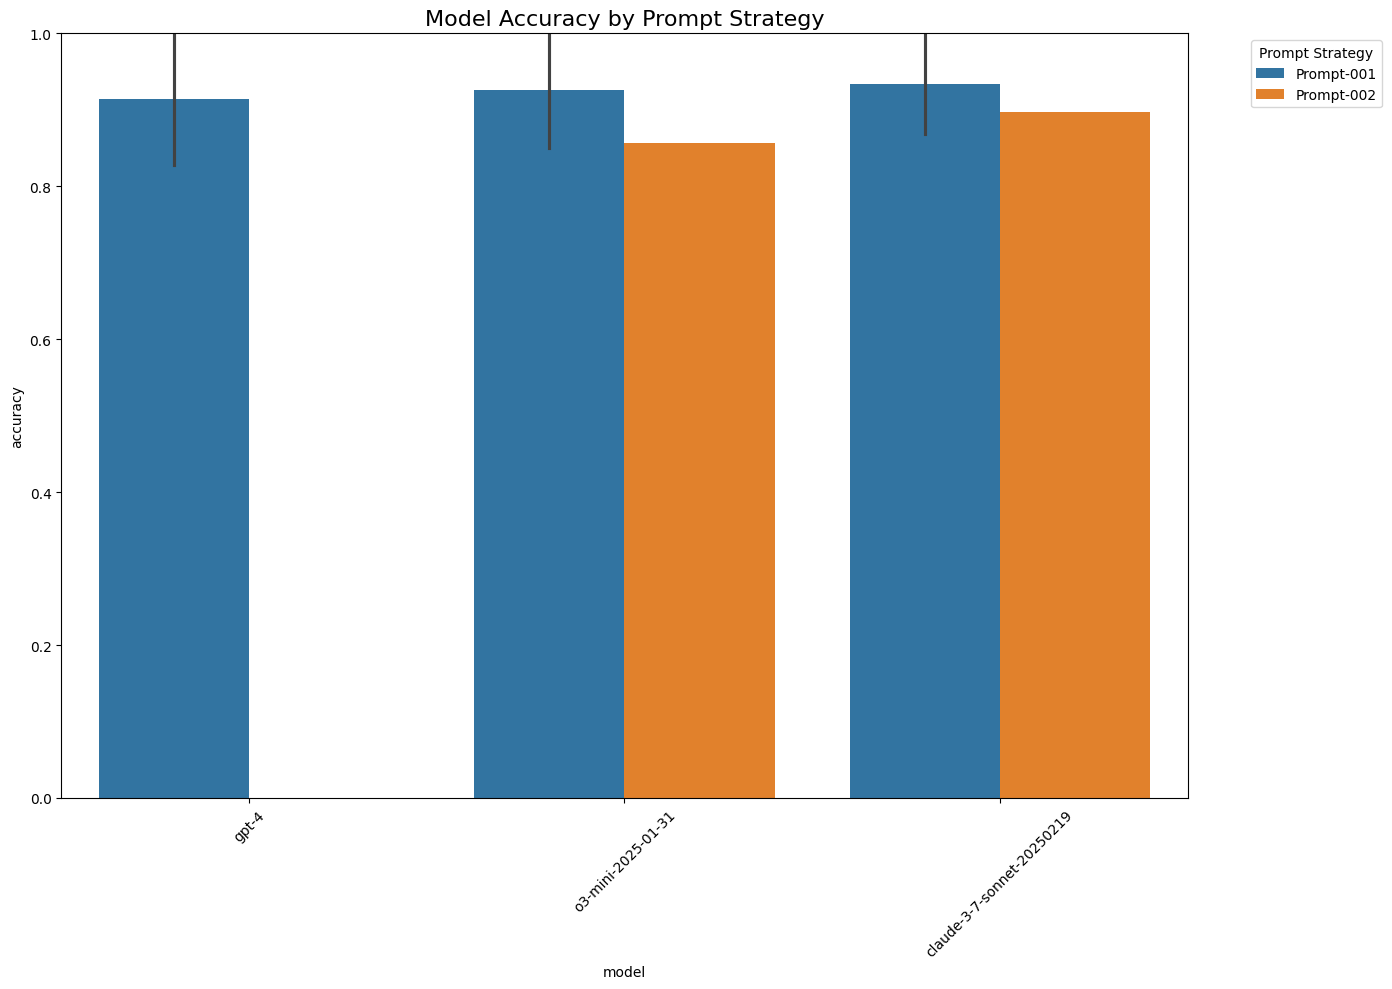

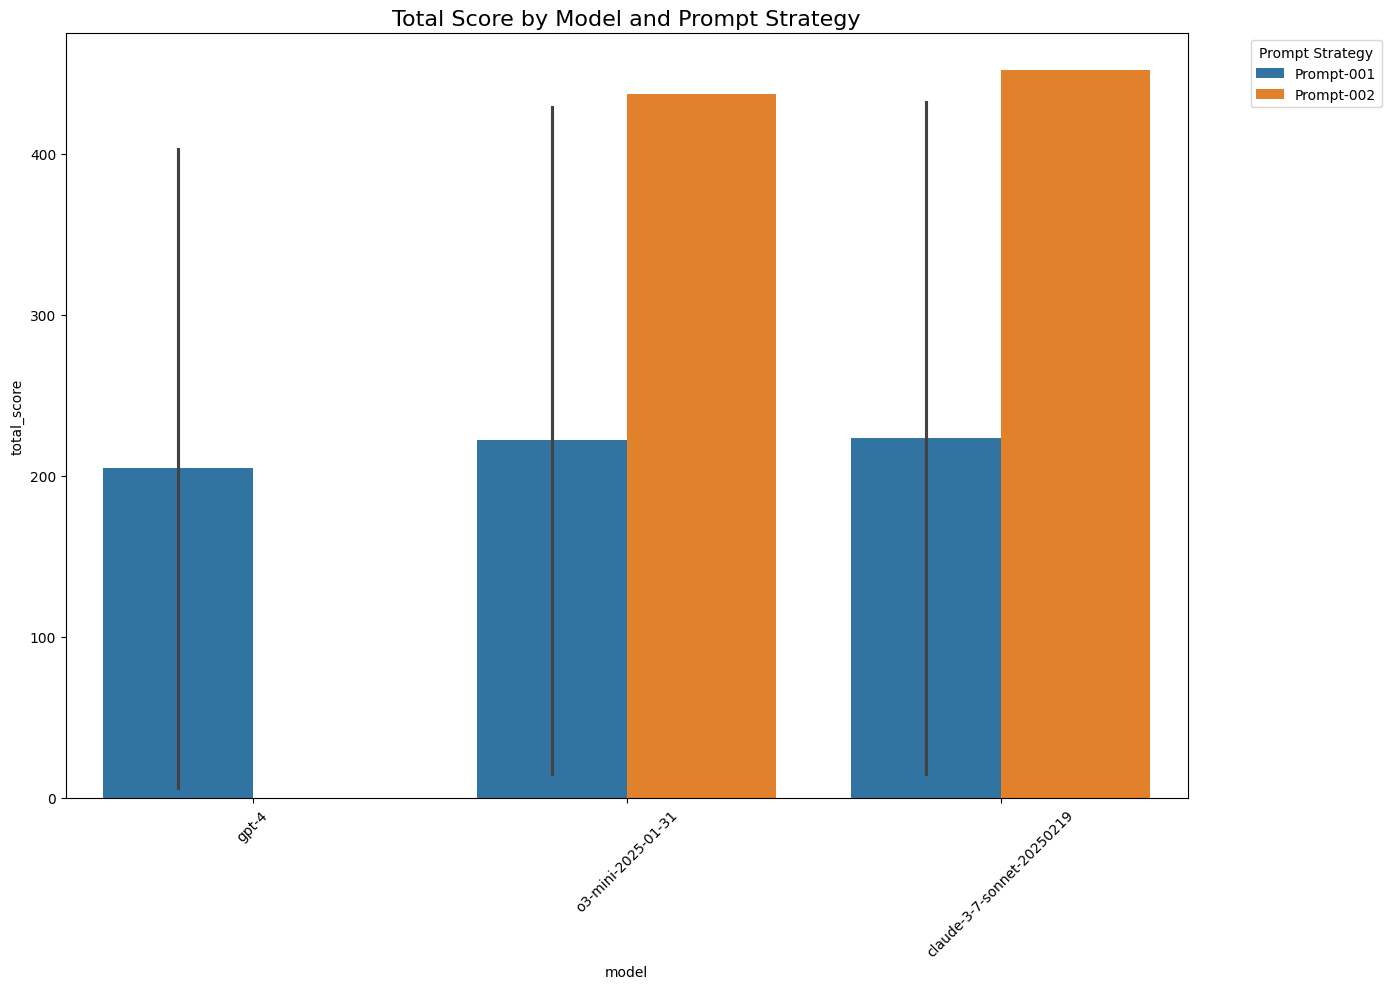

✓ Results also exported to: data/results/prompting-strategy


In [ ]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shutil

# ---------------------------
# Step 1: Load and Merge Evaluation Results
# ---------------------------
def merge_results(result_files):
    """Merge evaluation summaries and details from all result files."""
    all_summaries = []
    all_details = []

    for file in result_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                results = json.load(f)
            all_summaries.append(results.get('summary', {}))
            # Note: In your current results, details are stored under "results" or "details"
            details = results.get('results', []) or results.get('details', [])
            all_details.extend(details)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return all_summaries, all_details

result_files = glob.glob("data/results/EVAL-MIR-2024-v01-t01-*.json")
print(f"Found {len(result_files)} evaluation result files.")

summaries, details = merge_results(result_files)
df_summary = pd.DataFrame(summaries)
df_details = pd.DataFrame(details)

print("Merged details shape:", df_details.shape)
print("Columns in details:", df_details.columns.tolist())

# ---------------------------
# Step 2: Compute Correctness
# ---------------------------
# Here we assume that the evaluator saved the model's answer in "model_answer"
# and the correct answer in "correct_answer". We create a boolean 'correct' column.
df_details['model_answer'] = df_details['model_answer'].astype(str).str.strip().str.upper()
df_details['correct_answer'] = df_details['correct_answer'].astype(str).str.strip().str.upper()
df_details['correct'] = df_details['model_answer'] == df_details['correct_answer']

# ---------------------------
# Step 3: Summarize Model Performance
# ---------------------------
df_model_summary = df_details.groupby("model").agg(
    total_questions=("question_id", "nunique"),
    correct_count=("correct", "sum")
).reset_index()
df_model_summary["accuracy"] = df_model_summary["correct_count"] / df_model_summary["total_questions"]

print("\n--- Model Performance Summary ---")
print(df_model_summary)

# ---------------------------
# Step 4: Identify Most Difficult Questions
# ---------------------------
# We define difficult questions as those with failures from at least one model.
df_failures = df_details[~df_details["correct"]]
df_failures_summary = df_failures.groupby("question_id").agg(
    failure_count=("model", "nunique"),
    models_failed=("model", lambda x: ", ".join(sorted(x.unique())))
).reset_index()

# Optionally, join with the prompt text if available (assume 'prompt' column exists)
if "prompt" in df_details.columns:
    prompt_info = df_details[["question_id", "prompt"]].drop_duplicates()
    df_failures_summary = df_failures_summary.merge(prompt_info, on="question_id", how="left")

df_failures_summary = df_failures_summary.sort_values("failure_count", ascending=False)

print("\n--- Most Difficult Questions (by number of model failures) ---")
print(df_failures_summary.head(10))

# ---------------------------
# Step 5: Export Data for Tableau
# ---------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = "data/exports"
os.makedirs(export_dir, exist_ok=True)
summary_csv = os.path.join(export_dir, f"evaluation_summary_{timestamp}.csv")
details_csv = os.path.join(export_dir, f"evaluation_details_{timestamp}.csv")

df_model_summary.to_csv(summary_csv, index=False)
df_details.to_csv(details_csv, index=False)
print(f"✓ Exported evaluation summary to: {summary_csv}")
print(f"✓ Exported evaluation details to: {details_csv}")

# ---------------------------
# Step 6: Visualize Results
# ---------------------------
plt.figure(figsize=(14, 10))
sns.barplot(x='model', y='accuracy', hue='prompt_strategy', data=df_summary)
plt.title('Model Accuracy by Prompt Strategy', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Prompt Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
accuracy_plot_path = os.path.join(export_dir, f"accuracy_comparison_{timestamp}.png")
plt.savefig(accuracy_plot_path, dpi=300)
plt.show()

plt.figure(figsize=(14, 10))
sns.barplot(x='model', y='total_score', hue='prompt_strategy', data=df_summary)
plt.title('Total Score by Model and Prompt Strategy', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Prompt Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
score_plot_path = os.path.join(export_dir, f"score_comparison_{timestamp}.png")
plt.savefig(score_plot_path, dpi=300)
plt.show()

# ---------------------------
# Step 7: Export Results to GitHub Folder (Optional)
# ---------------------------
github_export_dir = os.path.join("data", "results", "prompting-strategy")
os.makedirs(github_export_dir, exist_ok=True)
shutil.copy2(summary_csv, github_export_dir)
shutil.copy2(details_csv, github_export_dir)
shutil.copy2(accuracy_plot_path, github_export_dir)
shutil.copy2(score_plot_path, github_export_dir)
print(f"✓ Results also exported to: {github_export_dir}")


In [ ]:
from google.colab import userdata
import os
import shutil
import subprocess
from datetime import datetime

# Define source directories for evaluation results and exports
source_results_dir = "data/results"
source_exports_dir = "data/exports"

# Define the new target directory for full MIR-2024 evaluation results
target_dir = os.path.join("data", "results", "MIR-2024_evaluation")
os.makedirs(target_dir, exist_ok=True)

print("Copying evaluation result files from 'data/results' to 'MIR-2024_evaluation'...")

# Copy all JSON, CSV, and PNG files from source_results_dir that are not already in a dedicated folder (like prompting-strategy)
for filename in os.listdir(source_results_dir):
    # Skip folders (including any existing export folders)
    file_path = os.path.join(source_results_dir, filename)
    if os.path.isdir(file_path):
        continue
    if filename.endswith((".json", ".csv", ".png")):
        dst_path = os.path.join(target_dir, filename)
        # If the file doesn't exist or is different, copy it.
        if not os.path.exists(dst_path):
            shutil.copy2(file_path, dst_path)
            print(f"Copied {file_path} to {dst_path}")
        else:
            print(f"Skipped copying {file_path} (already exists in target)")

print("\nCopying export files from 'data/exports' to 'MIR-2024_evaluation'...")

# Copy CSV and PNG export files from the exports folder to the target directory
for filename in os.listdir(source_exports_dir):
    if filename.endswith((".csv", ".png")):
        src_path = os.path.join(source_exports_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)
            print(f"Copied {src_path} to {dst_path}")
        else:
            print(f"Skipped copying {src_path} (already exists in target)")

# --------------------------
# Step 2: Push the Updated Files to GitHub
# --------------------------
try:
    # Retrieve GitHub token from Colab secrets
    github_token = userdata.get('GITHUB_TOKEN')
    if not github_token:
        raise ValueError("GITHUB_TOKEN is not set in Colab secrets.")

    # Define repository name and construct the token URL
    repo_name = "armelida/MELIDA"
    token_url = f"https://{github_token}@github.com/{repo_name}.git"

    # Configure Git user details (adjust as needed)
    subprocess.run(["git", "config", "--global", "user.email", "armelida@gmail.com"], check=True)
    subprocess.run(["git", "config", "--global", "user.name", "Armelida"], check=True)

    # Update the remote URL to include the token
    subprocess.run(["git", "remote", "set-url", "origin", token_url], check=True)

    # Stage all changes (including the MIR-2024_evaluation folder)
    subprocess.run(["git", "add", "-A"], check=True)

    # Commit changes (if any)
    commit_message = f"Auto commit evaluation results for MIR-2024 from {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    commit_proc = subprocess.run(
        ["git", "commit", "-m", commit_message],
        capture_output=True,
        text=True
    )
    print("Git commit output:", commit_proc.stdout, commit_proc.stderr)

    # Pull the latest changes with rebase
    pull_proc = subprocess.run(
        ["git", "pull", "origin", "main", "--rebase"],
        capture_output=True,
        text=True,
        check=True
    )
    print("Git pull output:", pull_proc.stdout, pull_proc.stderr)

    # Push the committed changes to GitHub
    push_proc = subprocess.run(
        ["git", "push", "origin", "main"],
        capture_output=True,
        text=True,
        check=True
    )
    print("Git push output:", push_proc.stdout, push_proc.stderr)
    print("Results successfully pushed to GitHub in MIR-2024_evaluation folder.")
except subprocess.CalledProcessError as cpe:
    print("Error during git operation:")
    print("Return code:", cpe.returncode)
    print("Output:", cpe.output)
    print("Error output:", cpe.stderr)
except Exception as e:
    print(f"Error pushing to GitHub: {e}")


Copying evaluation result files from 'data/results' to 'MIR-2024_evaluation'...
Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.json to data/results/MIR-2024_evaluation/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.json
Copied data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250326-154417.json to data/results/MIR-2024_evaluation/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250326-154417.json
Copied data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250326-154417.csv to data/results/MIR-2024_evaluation/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-claude-3-7-sonnet-20250219-20250326-154417.csv
Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-225634.json to data/results/MIR-2024_evaluation/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-225634.json
Copied data/results/EVAL-MIR-2024-v01-t01_filtered-Prompt-001-o3-mini-20